In [ ]:
#map TFs binding a promoter to their relevant coefficient of variation - see if they correspond to constitutive or variable
#this script will work for any promoter length

In [6]:
import pandas as pd
#import argparse
import os
import seaborn as sns
import matplotlib.pyplot as plt
#stats
from pingouin import kruskal
import scikit_posthocs as sp
from scipy import stats

In [7]:
# parser = argparse.ArgumentParser(description='map_TF2CV')
# parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
# parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
# parser.add_argument('Czechowski_all_cvs', type=str, help='Input location of Czechowski coefficient of variations for all genes in the microarray')
# parser.add_argument('mapped_motif_bed', type=str, help='Input location of promoters mapped motif bed')
# parser.add_argument('output_folder_name', type=str, help='Optional output folder name ending in a forward slash',default = '')

In [8]:
dependent_variable = 'TFBS_TF_class'
file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
Czechowski_rankedcv = f'../../data/genes/AtGE_dev_gcRMA__all_probes__CV.tsv'
mapped_motif_bed = f'../../data/output/{file_names}/FIMO/promoters_5UTR_400bp_motifs_mapped.bed'
output_folder_name = 'promoters_5UTR_400bp/'

In [9]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class  already exists


In [10]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class/promoters_5UTR_400bp/  already exists


In [11]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class/promoters_5UTR_400bp/plots  already exists


In [12]:
def map_cv(ranked_cvs_file,mapped_motifs_file):
    """function to map the CV value to the TFs which bind to each promoter"""
    #read in files
    cvs = pd.read_table(ranked_cvs_file, sep='\t', header=None)
    cols = ['rank','probe_id','TF_AGI','expression_mean','expression_SD','expression_CV','proportion_of_values_present_in_mas5','presence_in_araport11','constitutive_in_araport11']
    cvs.columns = cols
    #filter out any genes that aren't present in araport11
    cvs = cvs[cvs.presence_in_araport11==1]
    
    mapped_motifs = pd.read_table(mapped_motifs_file, sep='\t', header=None)
    #if whole promoter, mapped motif will have 13 columns
    #if shortened promoter, mapped motif file will have 24 (as bp overlap is needed in TF_diversity_plots_shortenedprom.py to remove TFBSs where the middle isn't in the promoter)
    #if 24 columns, only select the subset of 13 columns
    #if 13 columns, keep them all
    #This is to make the dfs have identical column names
    if len(mapped_motifs.columns) == 24:
        cols = ['chr', 'start', 'stop', 'promoter_AGI','dot1','strand','source','type','dot2','attributes',
            'motif_chr','motif_start','motif_stop','name_rep', 'score', 'motif_strand',
            'promoter_AGI2', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI','bp_overlap']
        mapped_motifs.columns = cols
        #filter columns
        mapped_motifs = mapped_motifs[['motif_chr','motif_start','motif_stop','name_rep', 'score', 'motif_strand',
             'promoter_AGI2', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']]
        #rename columns
        cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
        mapped_motifs.columns = cols
        
    else:
        cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
        mapped_motifs.columns = cols
    #merge CV df with mapped_motifs, adding the CVs to the respective TF AGIs
    merged = pd.merge(mapped_motifs, cvs, how='left', on='TF_AGI')
    return merged

In [13]:
def merge_genetype(df, gene_categories):
    """merge df with gene_categories file adding the genetype of the promoters (if in top 100 constitutive or top 100 variable promoters)"""
    gene_cats = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['promoter_AGI','gene_type']
    gene_cats.columns = cols
    merged = pd.merge(gene_cats,df, on='promoter_AGI', how='left')
    return merged

In [14]:
def calculate_mean_SD_CV(df):
    """calculate the mean coefficient of variation of the tFs binding to a promoter"""
    #group by promoter and calculate mean for each promoter
    means = df.groupby('promoter_AGI')['expression_CV'].mean()
    #turn into a dataframe
    means_df = pd.DataFrame(means)
    #turn the index into a new column
    means_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['promoter_AGI', 'mean_cv']
    means_df.columns = cols
    
        
    #group by promoter and calculate SD (standard deviation) for each promoter
    sd = df.groupby('promoter_AGI')['expression_CV'].std()
    #turn into a dataframe
    sd_df = pd.DataFrame(sd)
    #turn the index into a new column
    sd_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['promoter_AGI', 'sd']
    sd_df.columns = cols
    
    #merge the dfs
    merged = pd.merge(means_df,sd_df)   
    return merged

In [15]:
def all_prom_distribution(df, x_variable, x_label, output_prefix):
    """function to return distribution plot of all promoters GC content"""    
    
    dist_plot = df[x_variable]
    #create figure with no transparency
    dist_plot_fig = sns.distplot(dist_plot).get_figure()
    plt.xlabel(x_label)

    #save to file
    dist_plot_fig.savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_distribution.pdf', format='pdf')

In [16]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot with specific column order
    plot = sns.catplot(x=x_variable, y=y_variable, data=df, kind=plot_kind, order=["constitutive", "variable", "control"])
    #plot points
    ax = sns.swarmplot(x=x_variable, y=y_variable, data=df, color=".25",order=["constitutive", "variable", "control"])
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')   

In [17]:
# def parallelize_dataframe(df, func, n_cores=4):
#     """parallelize the plot making"""
#     df_split = np.array_split(df, n_cores)
#     pool = Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

In [18]:
#map coefficient of variation (CV) values to each TF in the mapped_motifs file
Czechowski_merged = map_cv(Czechowski_rankedcv, mapped_motif_bed)

In [19]:
Czechowski_merged.columns

Index(['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI',
       'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family',
       'TF_AGI', 'rank', 'probe_id', 'expression_mean', 'expression_SD',
       'expression_CV', 'proportion_of_values_present_in_mas5',
       'presence_in_araport11', 'constitutive_in_araport11'],
      dtype='object')

In [20]:
#add gene_types for the promoters (constitutive, variable or control)
Czechowski_genetypes = merge_genetype(Czechowski_merged, Czechowski_gene_categories)

In [21]:
#calculate CV means per promoter
Czechowski_means_sd = calculate_mean_SD_CV(Czechowski_genetypes)

In [22]:
Czechowski_means_sd_genetype = merge_genetype(Czechowski_means_sd, Czechowski_gene_categories)

In [23]:
#remove promoters with no mean_cv
Czechowski_means_sd_genetype = Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.mean_cv.notnull()]

In [24]:
#check how many of each promoter type have mean_cv values
#constitutive
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'constitutive'])

92

In [25]:
#variable
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'variable'])

96

In [26]:
#control
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'control'])

98

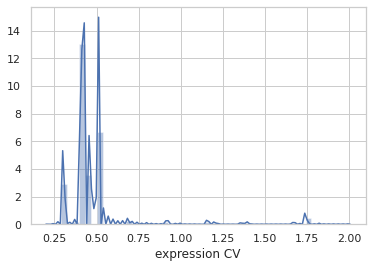

In [32]:
#plot all promoter distribution of TF CV values
all_prom_distribution(Czechowski_merged, 'expression_CV', 'expression CV', 'Czechowski_expressionCV')

## the CV values seem to mainly have low CVs so tend towards constitutive as in Czechowski et al 2005

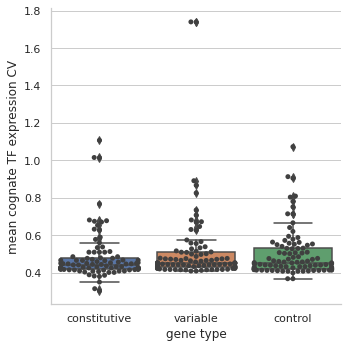

In [34]:
#plot the mean CV for each promoter gene_type
make_plot(Czechowski_means_sd_genetype,'gene_type', 'mean_cv','gene type', 'mean cognate TF expression CV', 'Czechowski_CV_mean', 'box')

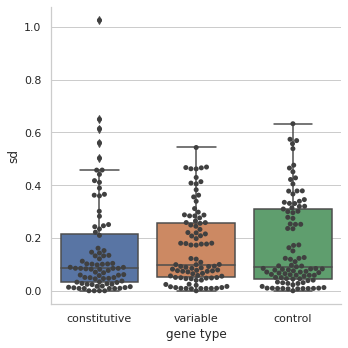

In [35]:
#plot the standard deviation of the CVs of the TFs binding each promoter split into gene_type
make_plot(Czechowski_means_sd_genetype,'gene_type', 'sd','gene type', 'sd', 'Czechowski_CV_sd', 'box')

## variable genes seem to have more variation in CV values of TFs that bind them. This makes sense since variable genes seem to have more diverse TFs binding them

In [31]:
# #now plot CV distribution for constitutive genes vs variable genes
#this took too long so commenting out for now
# make_plot(Czechowski_genetypes,'gene_type', 'expression_CV','gene type', 'expression CV', 'Czechowski_CV', 'box')

In [256]:
def test_normality(df,dependent_variable, between):
    """test normality of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #Test normality
    #returns test statistic, p-value
    for name in names:
        print('{}: {}'.format(name, stats.shapiro(df[dependent_variable][df[between] == name])))

In [257]:
def describe_stats(df,dependent_variable, between):
    """return descriptve statistics"""
    return df.groupby([between])[dependent_variable].describe()

In [258]:
def variance(df, dependent_variable, between):
    """test variance of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #test variance    
    return stats.levene(df[dependent_variable][df[between] == names[0]], 
               df[dependent_variable][df[between] == names[1]], 
               df[dependent_variable][df[between] == names[2]])

In [259]:
def kruskal_test(df,dependent_variable,between):
    """Do Kruskal-Wallis analysis"""
    #Kruskal-Wallis one way analysis of variance
    return kruskal(data=df, dv=dependent_variable, between=between)
    

In [260]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

In [261]:
#rename df for easier analysis
df = Czechowski_means_sd_genetype
between_variable = 'gene_type'
dependent_variable = 'mean_cv'

In [262]:
test_normality(df,dependent_variable,between_variable)

constitutive: (0.6664206981658936, 3.78886212768631e-13)
variable: (0.44895511865615845, 2.768671779271755e-17)
control: (0.7352134585380554, 5.296764329226766e-12)


## not normal

In [264]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=0.18112500547820584, pvalue=0.8344276976963958)

### fail to reject null hypothesis that variances are equal

In [265]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,92.0,0.481229,0.131947,0.302666,0.418921,0.442561,0.480784,1.107077
control,98.0,0.499321,0.125808,0.367514,0.420736,0.450062,0.530750,1.072997
variable,96.0,0.513512,0.204755,0.408771,0.430675,0.450577,0.508519,1.739770


In [266]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,4.392087,0.111242


In [ ]:
#not a significant difference in CV values between constitutive and variable or control 400bp promoters

In [268]:
# dunn_posthoc_test(df, dependent_variable,between_variable)

In [ ]:
## test to see if difference in standard_deviation between CV values of TFs binding each promoter for each promoter gene type

In [269]:
#rename df for easier analysis
df = Czechowski_means_sd_genetype
between_variable = 'gene_type'
dependent_variable = 'sd'

In [270]:
test_normality(df,dependent_variable,between_variable)

constitutive: (nan, 1.0)
variable: (nan, 1.0)
control: (nan, 1.0)


In [271]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,83.0,0.153508,0.185197,0.0,0.031977,0.084909,0.215779,1.024733
control,93.0,0.175267,0.166701,0.0,0.046185,0.091026,0.309716,0.632711
variable,90.0,0.166241,0.142964,0.0,0.050341,0.099339,0.258423,0.542744


In [272]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,1.955415,0.376173


In [ ]:
## no significant difference in TFBS CV sd between the promoter types